# Evaluation

In [52]:
import pandas as pd
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2

from agent.dqn import DQN

## Steigerung des Reward
Innerhalb dieses Notebooks findet eine Evaluation des Agenten statt, der über 500 Episoden auf der *CarRacing-v2*-Umgebung der gymnasium-Bibliothek trainiert wurde. 

In [58]:
reward_history = pd.read_csv("reward_history.csv")
reward_history.describe()

,episode,total_reward
count,500.000000,500.000000
mean,250.500000,26.339671
std,144.481833,30.773325
min,1.000000,-0.100000
25%,125.750000,5.103779
50%,250.500000,10.139005
75%,375.250000,47.996243
max,500.000000,154.873134


Während des Trainings konnte ein maximaler kumulierter Reward von 154,87 erreicht werden.

In [60]:
reward_history["rolling mean"] = reward_history["total_reward"].rolling(window=100, min_periods=1).mean()

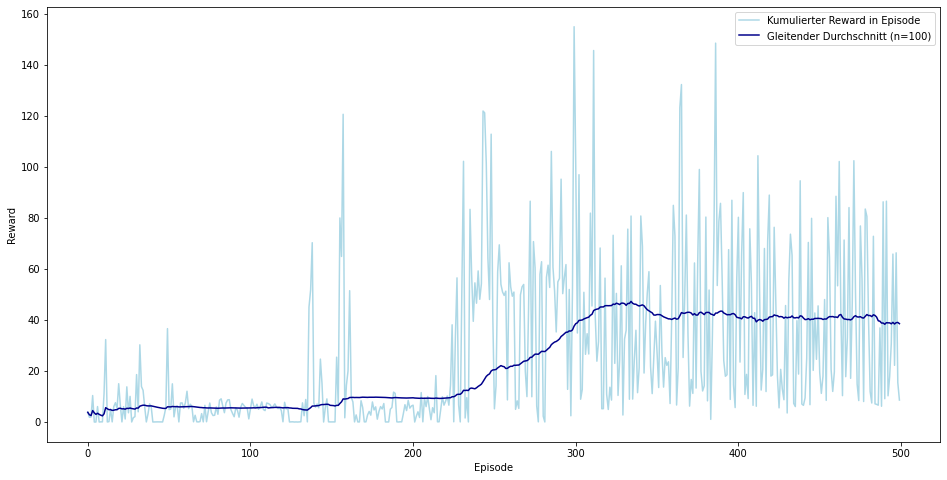

In [41]:
fig, ax = plt.subplots(figsize=(16, 8),)
reward_history["total_reward"].plot(ax=ax, xlabel="Episode", ylabel="Reward", color="lightblue")
reward_history["rolling mean"].plot(ax=ax,xlabel="Episode", ylabel="Reward", color="darkblue")
ax.legend(["Kumulierter Reward in Episode", "Gleitender Durchschnitt (n=100)"])

Insbesondere ab circa Episode 210 bis 330 ist ein deutlicher Anstieg des durchschnittlichen Reward von ungefähr 15 auf 42 zu vernehmen. Anschließend erreicht der Agent ein weiteres Plateau. Es könnte sein, dass die Begrenzung der negativen Rewards auf maximal 10 aufeinander folgende das Training einschränkt und verhindert, dass der Agent einen noch besseren Reward erreicht.

In [62]:
reward_history["rolling mean"].head(330)

0       3.714815
1       2.738276
2       2.440512
3       4.401067
4       3.502709
         ...    
325    46.489439
326    46.263007
327    45.940791
328    46.485920
329    46.512928
Name: rolling mean, Length: 330, dtype: float64

## Fähigkeiten des Agenten nach 5 Episoden
Am Anfang des Trainings konnte der Agent nicht gerade aus fahren und führte eine Aktion dauerhaft durch.

![](episode_5.gif)

In [46]:
def process_state_image(state):
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
    state = state.astype(float)
    return state / 255.0

action_space = [
    (-1, 1, 0.5), (0, 1, 0.5), (1, 1, 0.5), # Action Space Structure
    (-1, 1,   0), (0, 1,   0), (1, 1,   0), # (Steering Wheel, Gas, Break)
    (-1, 0, 0.5), (0, 0, 0.5), (1, 0, 0.5), # Range -1~1       0~1   0~1
    (-1, 0,   0), (0, 0,   0), (1, 0,   0)
]
state_shape = (96, 96, 1)

reward_history = []

env = gym.make("CarRacing-v2", render_mode="human")
agent = DQN(action_space, state_shape)
agent.model.load_weights("models/trial_5/dqn")
agent.epsilon = agent.epsilon_min

state, info = env.reset()
state = process_state_image(state)
total_reward = 0
action_counter = 1
done = False

while not done:
    action = agent.act(state)

    next_state, reward, done, truncated, info = env.step(action)

    next_state = process_state_image(next_state)

    total_reward += reward

    state = next_state

    if action_counter > 300:
        done = True

    print(f"Action: {action_counter}, Reward: {reward}, Total Reward: {total_reward}")
    reward_history += [total_reward]
    action_counter += 1

env.close()

Action: 1, Reward: 7.094244604316547, Total Reward: 7.094244604316547
Action: 2, Reward: -0.09999999999999964, Total Reward: 6.994244604316547
Action: 3, Reward: -0.09999999999999964, Total Reward: 6.8942446043165475
Action: 4, Reward: -0.09999999999999964, Total Reward: 6.794244604316548
Action: 5, Reward: -0.09999999999999964, Total Reward: 6.694244604316548
Action: 6, Reward: -0.09999999999999964, Total Reward: 6.594244604316549
Action: 7, Reward: -0.09999999999999964, Total Reward: 6.494244604316549
Action: 8, Reward: -0.09999999999999964, Total Reward: 6.394244604316549
Action: 9, Reward: -0.09999999999999964, Total Reward: 6.29424460431655
Action: 10, Reward: -0.09999999999999964, Total Reward: 6.19424460431655
Action: 11, Reward: -0.09999999999999964, Total Reward: 6.09424460431655
Action: 12, Reward: 3.4971223021582727, Total Reward: 9.591366906474823
Action: 13, Reward: -0.09999999999999964, Total Reward: 9.491366906474823
Action: 14, Reward: -0.09999999999999964, Total Reward

## Fähigkeiten des Agenten nach 300 Episoden
Im Verlauf des Trainings lernte der Agent geraus zu fahren und konnte so den Reward ab Episode 210 deutlich erhöhen. Das Fahren von Kurven wurde jedoch nicht gelernt, sodass er immer weiter geradeaus fährt. Interessanterweise versucht er das Ende der Welt und den damit verbunden Reward von -100 zu umgehen.

![](episode_300.gif)

Eine mögliche Ursache könnte der Abbruch nach 10 aufeinander folgende Aktionen sein, die zu einem negativen Reward führen.

In [47]:
def process_state_image(state):
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
    state = state.astype(float)
    return state / 255.0

action_space = [
    (-1, 1, 0.5), (0, 1, 0.5), (1, 1, 0.5), # Action Space Structure
    (-1, 1,   0), (0, 1,   0), (1, 1,   0), # (Steering Wheel, Gas, Break)
    (-1, 0, 0.5), (0, 0, 0.5), (1, 0, 0.5), # Range -1~1       0~1   0~1
    (-1, 0,   0), (0, 0,   0), (1, 0,   0)
]
state_shape = (96, 96, 1)

reward_history = []

env = gym.make("CarRacing-v2", render_mode="human")
agent = DQN(action_space, state_shape)
agent.model.load_weights("models/trial_300/dqn")
agent.epsilon = agent.epsilon_min

state, info = env.reset()
state = process_state_image(state)
total_reward = 0
action_counter = 1
done = False

while not done:
    action = agent.act(state)

    next_state, reward, done, truncated, info = env.step(action)

    next_state = process_state_image(next_state)

    total_reward += reward

    state = next_state

    if action_counter > 10000:
        done = True

    print(f"Action: {action_counter}, Reward: {reward}, Total Reward: {total_reward}")
    reward_history += [total_reward]
    action_counter += 1

env.close()

Action: 1, Reward: 7.36268656716418, Total Reward: 7.36268656716418
Action: 2, Reward: -0.09999999999999964, Total Reward: 7.26268656716418
Action: 3, Reward: -0.09999999999999964, Total Reward: 7.16268656716418
Action: 4, Reward: -0.09999999999999964, Total Reward: 7.062686567164181
Action: 5, Reward: -0.09999999999999964, Total Reward: 6.962686567164181
Action: 6, Reward: -0.09999999999999964, Total Reward: 6.8626865671641815
Action: 7, Reward: -0.09999999999999964, Total Reward: 6.762686567164182
Action: 8, Reward: -0.09999999999999964, Total Reward: 6.662686567164182
Action: 9, Reward: -0.09999999999999964, Total Reward: 6.5626865671641825
Action: 10, Reward: -0.09999999999999964, Total Reward: 6.462686567164183
Action: 11, Reward: -0.09999999999999964, Total Reward: 6.362686567164183
Action: 12, Reward: -0.09999999999999964, Total Reward: 6.262686567164184
Action: 13, Reward: -0.09999999999999964, Total Reward: 6.162686567164184
Action: 14, Reward: -0.09999999999999964, Total Rewa

## Fähigkeiten des Agenten nach 330 Episoden
In Episode 330 hat der Agent den besten Zustand erreicht. In dieser Fassung schafft er es, die erste Linkskurve zu nehmen.

![](episode_330.gif)

Im weiteren Verlauf des Trainings verlernte er das Kurvenfahren wieder.

In [66]:
def process_state_image(state):
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
    state = state.astype(float)
    return state / 255.0

action_space = [
    (-1, 1, 0.5), (0, 1, 0.5), (1, 1, 0.5), # Action Space Structure
    (-1, 1,   0), (0, 1,   0), (1, 1,   0), # (Steering Wheel, Gas, Break)
    (-1, 0, 0.5), (0, 0, 0.5), (1, 0, 0.5), # Range -1~1       0~1   0~1
    (-1, 0,   0), (0, 0,   0), (1, 0,   0)
]
state_shape = (96, 96, 1)

reward_history = []

env = gym.make("CarRacing-v2", render_mode="human")
agent = DQN(action_space, state_shape)
agent.model.load_weights("models/trial_330/dqn")
agent.epsilon = agent.epsilon_min

state, info = env.reset()
state = process_state_image(state)
total_reward = 0
action_counter = 1
done = False

while not done:
    action = agent.act(state)

    next_state, reward, done, truncated, info = env.step(action)

    next_state = process_state_image(next_state)

    total_reward += reward

    state = next_state

    if action_counter > 300:
        done = True

    print(f"Action: {action_counter}, Reward: {reward}, Total Reward: {total_reward}")
    reward_history += [total_reward]
    action_counter += 1

env.close()

Action: 1, Reward: 6.8204152249134955, Total Reward: 6.8204152249134955
Action: 2, Reward: -0.09999999999999964, Total Reward: 6.720415224913496
Action: 3, Reward: -0.09999999999999964, Total Reward: 6.620415224913496
Action: 4, Reward: -0.09999999999999964, Total Reward: 6.520415224913497
Action: 5, Reward: -0.09999999999999964, Total Reward: 6.420415224913497
Action: 6, Reward: -0.09999999999999964, Total Reward: 6.320415224913497
Action: 7, Reward: -0.09999999999999964, Total Reward: 6.220415224913498
Action: 8, Reward: -0.09999999999999964, Total Reward: 6.120415224913498
Action: 9, Reward: -0.09999999999999964, Total Reward: 6.020415224913498
Action: 10, Reward: -0.09999999999999964, Total Reward: 5.920415224913499
Action: 11, Reward: -0.09999999999999964, Total Reward: 5.820415224913499
Action: 12, Reward: 3.3602076124567484, Total Reward: 9.180622837370247
Action: 13, Reward: -0.09999999999999964, Total Reward: 9.080622837370248
Action: 14, Reward: -0.09999999999999964, Total Re

## Konklusion

Zusammenfassend kann der DQN Agent lernen, das Auto geradeaus zu steuern. Das Fahren von Kurven wurde während des Trainings ebenfalls erlernt, jedoch im weiteren Training wieder verlernt. Als limitierende Faktoren können die Batchsize von 16 und das Ausführen der Replay-Funktion alle 5 Frames zu diesem Verlernen beigetragen haben. Darüber hinaus kann es auch von Vorteil sein, den Epsilon-Decay zu verringern, um zu anfangs noch mehr Exploration zu erlauben. Ein Training auf leistungsstärkerer Hardware mit weiteren Episoden kann schließlich die Performance des Agenten weiter verbessern.